In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import string
alphabet = list(string.ascii_lowercase)       

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

## Green's Function

In [3]:
G_ds_path = 'Outputs/G_pulse_ds.nc4'
G_cdr_ds_path = 'Outputs/G_cdr_ds.nc4'

G_ds = utils.import_polyfit_G(G_ds_path, G_cdr_ds_path)

## Convolution

In [4]:
conv_mean_ds = xr.open_dataset('Outputs/conv_mean_ds.nc4')['__xarray_dataarray_variable__']

conv_ds = xr.open_dataset('Outputs/conv_ds.nc4')['__xarray_dataarray_variable__']

## CMIP6 1pct

In [5]:
ds_dif = xr.open_dataset('Outputs/ds_dif.nc4')

## Emissions profile

In [6]:
emis_profile = xr.open_dataset('Outputs/emis_profile.nc4')


## RTCRE

In [7]:
RTCRE = xr.open_dataset('Outputs/RTCRE.nc')

# Settings and Define our Model Weights

In [8]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = utils.model_weights

onepct_model_weights = utils.onepct_model_weights

G_model_weights = utils.G_model_weights

In [9]:
type_color = utils.type_color

In [10]:
A = utils.A
ds_out = utils.ds_out

# Two trajectories with same cumulative emis

In [12]:
#https://climateactiontracker.org/global/temperatures/ for emissions trajectory

In [13]:
slow_decrease = np.concatenate([np.arange(10.,30., 1.), np.arange(30.,0.,-1.)])
slow_decrease = np.concatenate([slow_decrease, np.zeros(50)])


sudden_decrease = np.concatenate([np.arange(10.,70., 3.), np.arange(70.,0., -10.)])
sudden_decrease = np.concatenate([sudden_decrease, np.zeros(len(slow_decrease)-len(sudden_decrease))])


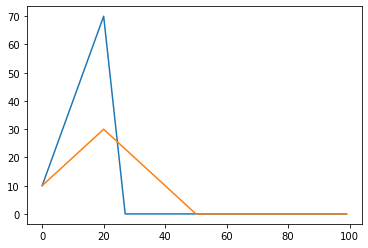

In [14]:
plt.plot(sudden_decrease)
plt.plot(slow_decrease)

In [15]:
mod_factor = np.cumsum(sudden_decrease)[-1]/np.cumsum(slow_decrease)[-1]

In [16]:
mod_factor

1.2280701754385965

In [17]:
slow_decrease[1:]*=mod_factor


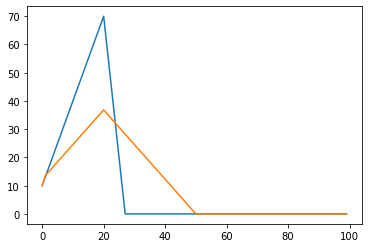

In [18]:
plt.plot(sudden_decrease)
plt.plot(slow_decrease)

In [19]:
dif = sudden_decrease.sum() - slow_decrease.sum()

In [20]:
slow_decrease[49] += dif/2

In [21]:
slow_decrease[50] += dif/2

In [22]:
%%time

GF = G_ds.weighted(G_model_weights).mean(dim = ['model', 'pulse_type'])

conv_sudden = signal.convolve(np.array(GF.dropna(dim = 's')), np.array(sudden_decrease)[..., None, None],'full')
conv_sudden = utils.np_to_xr(conv_sudden, GF, sudden_decrease)

conv_slow = signal.convolve(np.array(GF.dropna(dim = 's')), np.array(slow_decrease)[..., None, None],'full')
conv_slow = utils.np_to_xr(conv_slow, GF, slow_decrease)


CPU times: user 2.65 s, sys: 1.18 s, total: 3.84 s
Wall time: 3.85 s


In [23]:
TCRE = RTCRE.weighted(A).mean(dim = ['lat','lon'])['__xarray_dataarray_variable__']


In [24]:
## hatch where we don't trust in the 1pct-1000pgc case
num_std = 1
plus_std = ds_dif['tas'].weighted(model_weights).mean(dim = 'model') + num_std*ds_dif['tas'].weighted(model_weights).std(dim = 'model')
minus_std = ds_dif['tas'].weighted(model_weights).mean(dim = 'model') - num_std*ds_dif['tas'].weighted(model_weights).std(dim = 'model')
ds_compare = conv_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type')

hatching = {}
yr_dif = 5
for t in [24, 50, 80]:
    hatching[t] = ((ds_compare.sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's') > 
                 minus_std.sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's')) & 
                (ds_compare.sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's') < 
                 plus_std.sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's')))

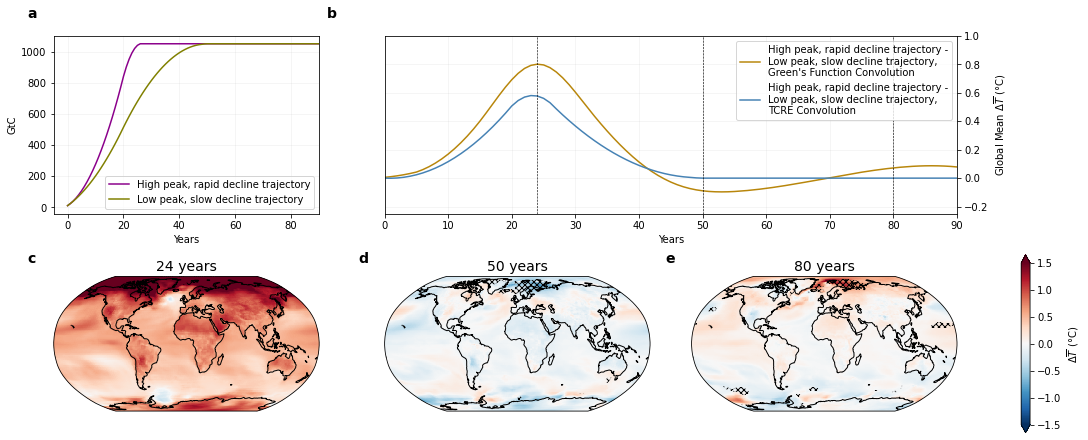

In [25]:
fig = plt.figure(figsize = [15,6], constrained_layout = True)
gs = GridSpec(2,3, figure = fig)
TCRE = G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'pulse_type').sel(s = slice(0,70)).weighted(model_weights).mean(dim = 'model').mean().values
####### cumulative emissions ########
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(np.cumsum(sudden_decrease), label = 'High peak, rapid decline trajectory', color = 'darkmagenta')
ax1.plot(np.cumsum(slow_decrease), label = 'Low peak, slow decline trajectory', color = 'olive')
ax1.set_ylabel('GtC')
ax1.set_xlabel('Years')
ax1.grid(alpha = 0.15)
ax1.legend()
ax1.set_xlim(None, 90)
####### global mean ############
ax2 = fig.add_subplot(gs[0,1:])
((conv_sudden.rolling(s = 10, min_periods = 1, center = True).mean('s')-conv_slow.rolling(s = 10, min_periods = 1, center = True).mean('s'))).mean(dim = ['lat','lon']).plot(ax = ax2, label = 'High peak, rapid decline trajectory -\nLow peak, slow decline trajectory,\nGreen\'s Function Convolution', color = 'darkgoldenrod')
#ax2.fill_between(np.arange(0,340),((conv_sudden-conv_slow)).mean(dim = ['lat','lon']).roll(s = -5), ((conv_sudden-conv_slow)).mean(dim = ['lat','lon']).roll(s = 5), alpha = .1, color = 'darkgoldenrod')
ax2.plot(np.cumsum((sudden_decrease -slow_decrease)*TCRE), label = 'High peak, rapid decline trajectory -\nLow peak, slow decline trajectory,\nTCRE Convolution', color = 'steelblue')

ax2.axvline(24, linestyle = '--', color = 'k', linewidth = .6)
ax2.axvline(50, linestyle = '--', color = 'k', linewidth = .6)
ax2.axvline(80, linestyle = '--', color = 'k', linewidth = .6)

ax2.set_xlim(0,90)
ax2.set_ylim(-.25,1)
ax2.set_ylabel('Global Mean $\Delta \overline{T}$ ($\degree$C)')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Years')
ax2.grid(alpha = 0.15)
ax2.legend()
####### Maps ###########

ax3 = fig.add_subplot(gs[1,0], projection = ccrs.Robinson())
ax4 = fig.add_subplot(gs[1,1], projection = ccrs.Robinson())
ax5 = fig.add_subplot(gs[1,2], projection = ccrs.Robinson())
cbar_arg = {24:None, 50:None, 80:{'label':'$\Delta \overline{T}$ ($\degree$C)'}}
cmap = mpl.cm.RdBu_r
levels = np.arange(-2,2)
vmin = -1.5
vmax = 1.5
##contours of convolution-1pct difference
for t, ax in zip(cbar_arg.keys(),[ax3, ax4, ax5]):
    if ax == ax3 or ax == ax4:
        add_cbar = False
    elif ax == ax5:
        add_cbar = True
    (conv_sudden-conv_slow).sel(s = slice(t-5, t+5)).mean(dim = 's').plot(ax = ax, 
                                                              cmap = cmap, vmin = vmin, vmax = vmax, extend = 'both', 
                                                              add_colorbar = add_cbar, cbar_kwargs= cbar_arg[t],     
                                                              transform = ccrs.PlateCarree())

    ##hatching for locations where convolution falls within 1std
    cs = hatching[t].sel(experiment = '1000gtc').plot.contourf(ax = ax, hatches = ['xxxx', ''], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)
    for i, collection in enumerate(cs.collections):
        collection.set_edgecolor('black')
    for collection in cs.collections:
        collection.set_linewidth(0.)
        
        
    ax.coastlines()
    ax.set_title(f'{t} years', fontsize = 14)
    
#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4, ax5]:
    label = next(alpha_labels)
    ax.text(x = -0.1, y = 1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

plt.savefig('figures/paper/figure4_example_emissions.png', dpi = 350, bbox_inches = 'tight')

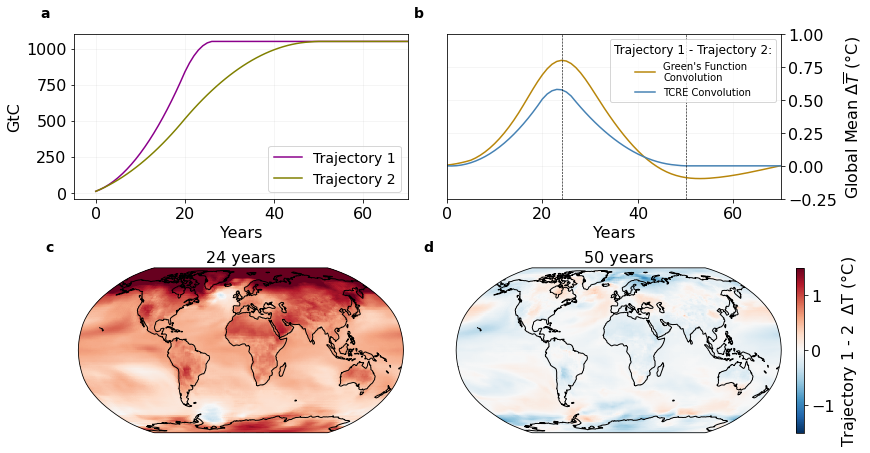

In [46]:
fig = plt.figure(figsize = [12,6], constrained_layout = True)
gs = GridSpec(2,2, figure = fig)
TCRE = G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'pulse_type').sel(s = slice(0,70)).weighted(model_weights).mean(dim = 'model').mean().values
####### cumulative emissions ########
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(np.cumsum(sudden_decrease), label = 'Trajectory 1', color = 'darkmagenta')
ax1.plot(np.cumsum(slow_decrease), label = 'Trajectory 2', color = 'olive')
ax1.set_ylabel('GtC', fontsize = 16)
ax1.set_xlabel('Years', fontsize = 16)
ax1.grid(alpha = 0.15)
ax1.legend(fontsize = 14)
ax1.set_xlim(None, 70)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
####### global mean ############
ax2 = fig.add_subplot(gs[0,1])
((conv_sudden.rolling(s = 10, min_periods = 1, center = True).mean('s')-conv_slow.rolling(s = 10, min_periods = 1, center = True).mean('s'))).mean(dim = ['lat','lon']).plot(ax = ax2, label = 'Green\'s Function\nConvolution', color = 'darkgoldenrod')
#ax2.fill_between(np.arange(0,340),((conv_sudden-conv_slow)).mean(dim = ['lat','lon']).roll(s = -5), ((conv_sudden-conv_slow)).mean(dim = ['lat','lon']).roll(s = 5), alpha = .1, color = 'darkgoldenrod')
ax2.plot(np.cumsum((sudden_decrease -slow_decrease)*TCRE), label = 'TCRE Convolution', color = 'steelblue')

ax2.axvline(24, linestyle = '--', color = 'k', linewidth = .6)
ax2.axvline(50, linestyle = '--', color = 'k', linewidth = .6)
#ax2.axvline(80, linestyle = '--', color = 'k', linewidth = .6)

ax2.set_xlim(0,70)
ax2.set_ylim(-.25,1)
ax2.set_ylabel('Global Mean $\Delta \overline{T}$ ($\degree$C)', fontsize = 16)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Years', fontsize = 16)
ax2.grid(alpha = 0.15)
ax2.legend(fontsize = 10, title = 'Trajectory 1 - Trajectory 2:', title_fontsize = 12)
ax2.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=16)
####### Maps ###########

ax3 = fig.add_subplot(gs[1,0], projection = ccrs.Robinson())
ax4 = fig.add_subplot(gs[1,1], projection = ccrs.Robinson())
#ax5 = fig.add_subplot(gs[1,2], projection = ccrs.Robinson())
cbar_arg = {24:None, 50:{'label':'Trajectory 1 - 2  $\Delta T$ ($\degree$C)'}}
cmap = mpl.cm.RdBu_r
levels = np.arange(-2,2)
vmin = -1.5
vmax = 1.5
##contours of convolution-1pct difference
for t, ax in zip(cbar_arg.keys(),[ax3, ax4]):#, ax5]):
    if ax == ax3:
        add_cbar = False
    elif ax == ax4:
        add_cbar = True
    fg = (conv_sudden-conv_slow).sel(s = slice(t-5, t+5)).mean(dim = 's').plot(ax = ax, 
                                                              cmap = cmap, vmin = vmin, vmax = vmax, extend = 'both', 
                                                              add_colorbar = False, #cbar_kwargs= cbar_arg[t],     
                                                              transform = ccrs.PlateCarree())


    ##hatching for locations where convolution falls within 1std
    ax.coastlines()
    ax.set_title(f'{t} years', fontsize = 16)
    
cbar = ax4.figure.colorbar(fg, ax=ax4, pad=-0.2)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label='Trajectory 1 - 2  $\Delta$T ($\degree$C)', size=16)

#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:#, ax5]:
    label = next(alpha_labels)
    ax.text(x = -0.1, y = 1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
plt.savefig('figures/poster/example_emissions.png', dpi = 350, bbox_inches = 'tight')


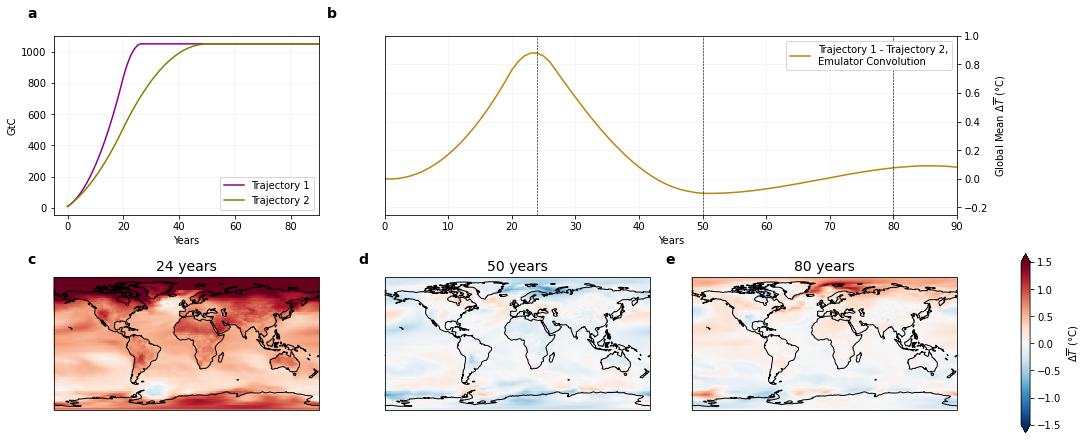

In [34]:
fig = plt.figure(figsize = [15,6], constrained_layout = True)
gs = GridSpec(2,3, figure = fig)
TCRE = G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'pulse_type').sel(s = slice(0,70)).weighted(model_weights).mean(dim = 'model').mean().values
####### cumulative emissions ########
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(np.cumsum(sudden_decrease), label = 'Trajectory 1', color = 'darkmagenta')
ax1.plot(np.cumsum(slow_decrease), label = 'Trajectory 2', color = 'olive')
ax1.set_ylabel('GtC')
ax1.set_xlabel('Years')
ax1.grid(alpha = 0.15)
ax1.legend()
ax1.set_xlim(None, 90)
####### global mean ############
ax2 = fig.add_subplot(gs[0,1:])
((conv_sudden-conv_slow)).mean(dim = ['lat','lon']).plot(ax = ax2, label = 'Trajectory 1 - Trajectory 2,\nGreen\'s Function Convolution', color = 'darkgoldenrod')

ax2.axvline(24, linestyle = '--', color = 'k', linewidth = .6)
ax2.axvline(50, linestyle = '--', color = 'k', linewidth = .6)
ax2.axvline(80, linestyle = '--', color = 'k', linewidth = .6)

ax2.set_xlim(0,90)
ax2.set_ylim(-.25,1)
ax2.set_ylabel('Global Mean $\Delta \overline{T}$ ($\degree$C)')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Years')
ax2.grid(alpha = 0.15)
ax2.legend()
####### Maps ###########

ax3 = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1,1], projection = ccrs.PlateCarree())
ax5 = fig.add_subplot(gs[1,2], projection = ccrs.PlateCarree())
cbar_arg = {24:None, 50:None, 80:{'label':'$\Delta \overline{T}$ ($\degree$C)'}}
cmap = mpl.cm.RdBu_r
levels = np.arange(-2,2)
vmin = -1.5
vmax = 1.5
##contours of convolution-1pct difference
for t, ax in zip(cbar_arg.keys(),[ax3, ax4, ax5]):
    if ax == ax3 or ax == ax4:
        add_cbar = False
    elif ax == ax5:
        add_cbar = True
    (conv_sudden-conv_slow).sel(s = slice(t-5, t+5)).mean(dim = 's').plot(ax = ax, 
                                                              cmap = cmap, vmin = vmin, vmax = vmax, extend = 'both', 
                                                              add_colorbar = add_cbar, cbar_kwargs= cbar_arg[t],     
                                                              transform = ccrs.PlateCarree())

    ##hatching for locations where convolution falls within 1std
    ax.coastlines()
    ax.set_title(f'{t} years', fontsize = 14)
    
#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4, ax5]:
    label = next(alpha_labels)
    ax.text(x = -0.1, y = 1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

plt.savefig('figures/talks/figure4_example_emissions.png', dpi = 350, bbox_inches = 'tight')

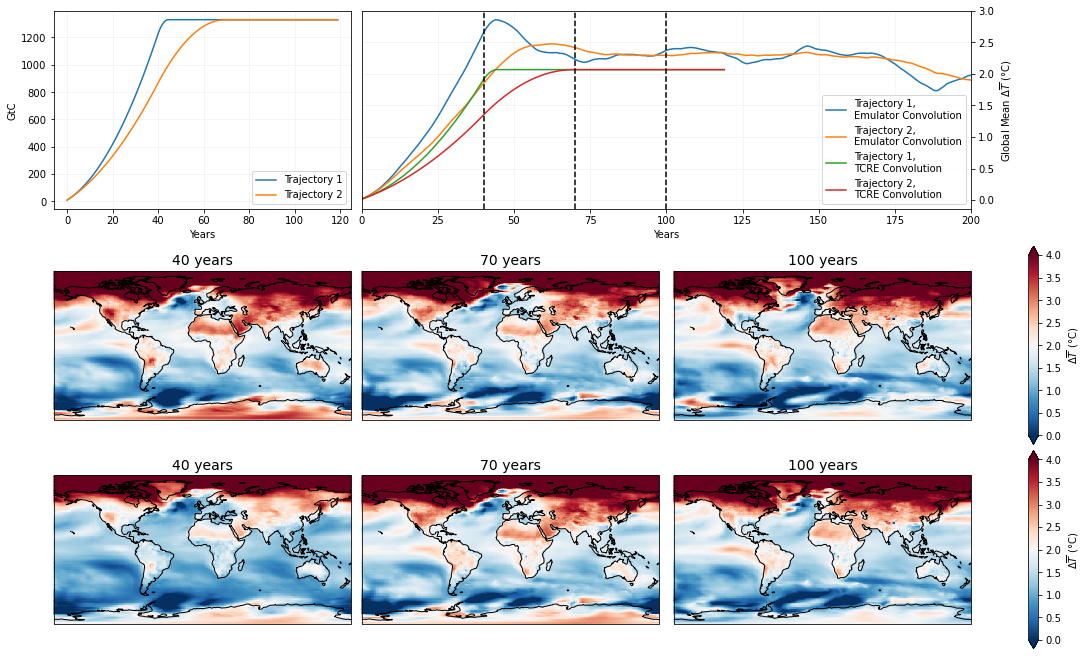

In [40]:
fig = plt.figure(figsize = [15,9], constrained_layout = True)
gs = GridSpec(3,3, figure = fig)
TCRE = G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'pulse_type').sel(s = slice(0,70)).weighted(model_weights).mean(dim = 'model').mean().values
####### cumulative emissions ########
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(np.cumsum(sudden_decrease), label = 'Trajectory 1')
ax1.plot(np.cumsum(slow_decrease), label = 'Trajectory 2')
ax1.set_ylabel('GtC')
ax1.set_xlabel('Years')
ax1.grid(alpha = 0.15)
ax1.legend()
####### global mean ############
ax2 = fig.add_subplot(gs[0,1:])
(conv_sudden).mean(dim = ['lat','lon']).plot(ax = ax2, label = 'Trajectory 1,\nGreen\'s Function Convolution')
(conv_slow).mean(dim = ['lat','lon']).plot(ax = ax2, label = 'Trajectory 2,\nGreen\'s FunctionEmulator Convolution')

ax2.plot(np.cumsum((sudden_decrease)*TCRE), label = 'Trajectory 1,\nTCRE Convolution')
ax2.plot(np.cumsum((slow_decrease)*TCRE), label = 'Trajectory 2,\nTCRE Convolution')

ax2.axvline(40, linestyle = '--', color = 'k')
ax2.axvline(60, linestyle = '--', color = 'k')
ax2.axvline(80, linestyle = '--', color = 'k')

ax2.set_xlim(0,200)
#ax2.set_ylim(-1,1)
ax2.set_ylabel('Global Mean $\Delta \overline{T}$ ($\degree$C)')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Years')
ax2.grid(alpha = 0.15)
ax2.legend()
####### Maps of trajectory 1 ###########

ax3 = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1,1], projection = ccrs.PlateCarree())
ax5 = fig.add_subplot(gs[1,2], projection = ccrs.PlateCarree())
cbar_arg = {40:None, 70:None, 100:{'label':'$\Delta \overline{T}$ ($\degree$C)'}}
cmap = mpl.cm.RdBu_r
levels = np.arange(-2,2)
vmin = 0
vmax = 4
##contours of convolution-1pct difference
for t, ax in zip(cbar_arg.keys(),[ax3, ax4, ax5]):
    if ax == ax3 or ax == ax4:
        add_cbar = False
    elif ax == ax5:
        add_cbar = True
    (conv_sudden).sel(s = slice(t-10, t+10)).mean(dim = 's').plot(ax = ax, 
                                                              cmap = cmap, vmin = vmin, vmax = vmax, extend = 'both', 
                                                              add_colorbar = add_cbar, cbar_kwargs= cbar_arg[t],     
                                                              transform = ccrs.PlateCarree())

    ##hatching for locations where convolution falls within 1std
    ax.coastlines()
    ax.set_title(f'{t} years', fontsize = 14)
    
####### Maps ###########

ax6 = fig.add_subplot(gs[2,0], projection = ccrs.PlateCarree())
ax7 = fig.add_subplot(gs[2,1], projection = ccrs.PlateCarree())
ax8 = fig.add_subplot(gs[2,2], projection = ccrs.PlateCarree())
cbar_arg = {40:None, 70:None, 100:{'label':'$\Delta \overline{T}$ ($\degree$C)'}}
cmap = mpl.cm.RdBu_r
levels = np.arange(-2,2)
vmin = 0
vmax = 4
##contours of convolution-1pct difference
for t, ax in zip(cbar_arg.keys(),[ax6, ax7, ax8]):
    if ax == ax6 or ax == ax7:
        add_cbar = False
    elif ax == ax8:
        add_cbar = True
    (conv_slow).sel(s = slice(t-10, t+10)).mean(dim = 's').plot(ax = ax, 
                                                              cmap = cmap, vmin = vmin, vmax = vmax, extend = 'both', 
                                                              add_colorbar = add_cbar, cbar_kwargs= cbar_arg[t],     
                                                              transform = ccrs.PlateCarree())

    ##hatching for locations where convolution falls within 1std
    ax.coastlines()
    ax.set_title(f'{t} years', fontsize = 14)